This notebook is a tutorial on using the sxs package to preprocess time-domain waveforms before Fourier transforming them. 

For detection purposes, gravitational waveforms are usually analyzed in the frequency domain. Those waveforms that are produced in the time domain need to be Fourier transformed to the frequency domain. We cannot simply apply fast-Fourier-transform (FFT) algorithms directly on the time-domain waveforms (in fact, most most time-domain signals), for the following reasons. FFT implicitly assumes the signal (as a time series) is periodic, so we can wrap around the signal in time and identify both ends of the signal. The two ends generally do not match and this mismatch can induce spectral leakage in the frequency-domain signal. Thus, we need to preprocess the signal before applying FFT. As we will see, in the context of waveforms, preprocessing includes four steps tail transitioning, padding, tapering, and detrending. Not all steps are required. 

Let us start by loading several necessary packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sxs
from sxs.waveforms.preprocessing import *

# Sample data: a sine wave

To better see the effects of each preprocessing step, let us consider a simple function: a sine wave.

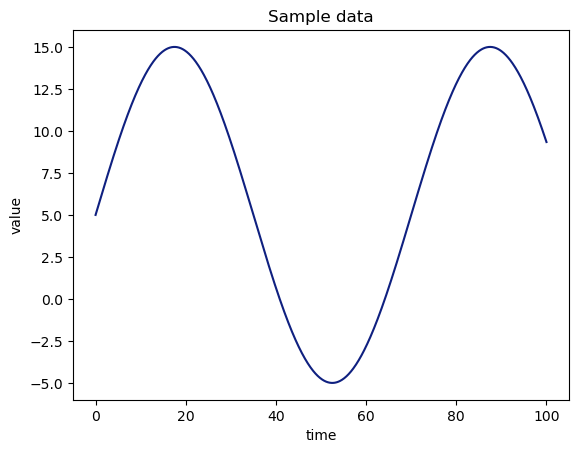

In [2]:
time = np.linspace(0, 100, 1000)
data = 10*np.sin(2*np.pi/70*time) + 5

plt.plot(time, data)
plt.title('Sample data')
plt.xlabel('time')
plt.ylabel('value');

## Tail transitioning

The function `transition_tail_to_constant` transitions the tail of the signal smoothly to a constant function. The figure below shows how the last 5 unit time trunk of data is transitioned to some constant function.

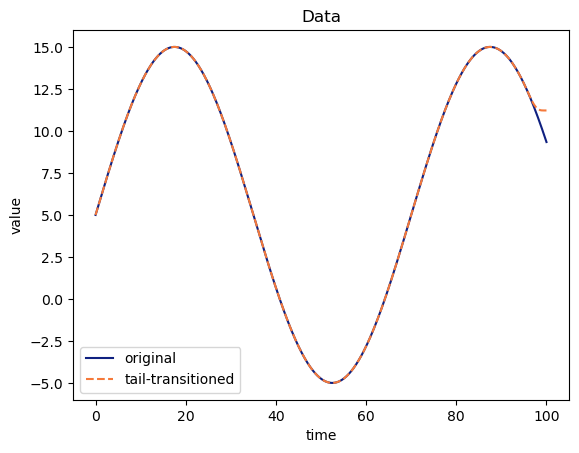

In [3]:
data_transitioned = transition_tail_to_constant(time, data, transition_length=5)

plt.plot(time, data, label='original')
plt.plot(time, data_transitioned, '--', label='tail-transitioned')
plt.legend()
plt.title('Data')
plt.xlabel('time')
plt.ylabel('value');

Below is an enlarged view of the transitioned part. You may be confused why we ever transition the signal's tail to a constant. Truly, this step does not make sense for these sample data, and we apply this step to the sample data merely for demonstration. The step of tail transitioning only makes sense if we expect the signal to settle down to some constant values at late times, e.g., a waveform that includes the ringdown phase.

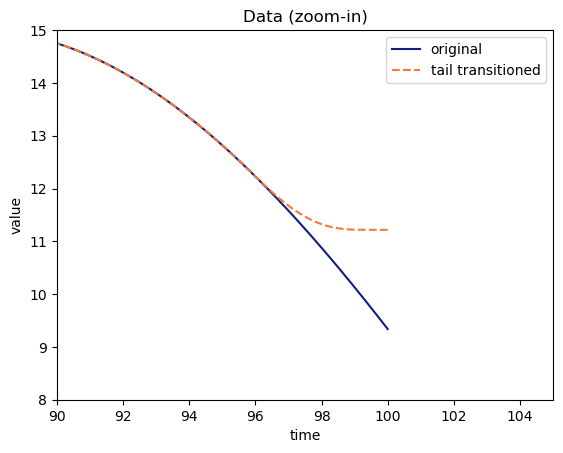

In [4]:
plt.plot(time, data, label='original')
plt.plot(time, data_transitioned, '--', label='tail transitioned')
plt.legend()
plt.xlim(90,105)
plt.ylim(8,15)
plt.title('Data (zoom-in)')
plt.xlabel('time')
plt.ylabel('value');

## Padding

The function `pad` pads the signal and extends the length of the signal. The argument `pad_type` controls by what values we pad the signal. We can pad the signal by its end values (`'edge'`) or zeros (`'zero'`). The input `time` array should be equally spaced.

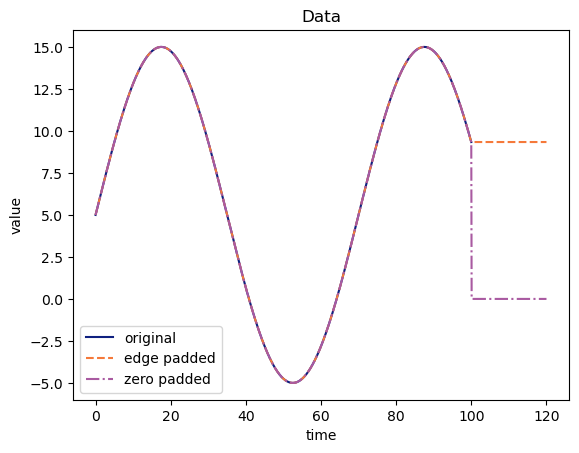

In [5]:
time_padded, data_padded_edge = pad(time, data, pad_type='edge', right_pad_length=20)
_, data_padded_zero = pad(time, data, pad_type='zero', right_pad_length=20)

plt.plot(time, data, label='original')
plt.plot(time_padded, data_padded_edge, '--', label='edge padded')
plt.plot(time_padded, data_padded_zero, '-.', label='zero padded')
plt.legend()
plt.title('Data')
plt.xlabel('time')
plt.ylabel('value');

The argument `left_pad_length` or `right_pad_length` controls how far we pad the left or right side.

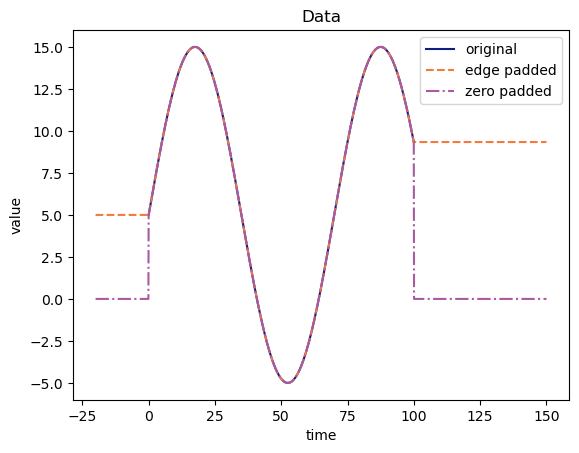

In [6]:
time_padded, data_padded_edge = pad(time, data, pad_type='edge', left_pad_length=20, right_pad_length=50)
_, data_padded_zero = pad(time, data, pad_type='zero', left_pad_length=20, right_pad_length=50)

plt.plot(time, data, label='original')
plt.plot(time_padded, data_padded_edge, '--', label='edge padded')
plt.plot(time_padded, data_padded_zero, '-.', label='zero padded')
plt.legend()
plt.title('Data')
plt.xlabel('time')
plt.ylabel('value');

## Tapering

### Taper function

A sigmoid function $f$ is merely a monotonic continuous function whose values are in $[0, 1]$. An increasing sigmoid satisfies $$ f(t_\mathrm{lower}) = 0 \quad \mathrm{and} \quad f(t_\mathrm{upper}) = 1. $$ A decreasing sigmoid satisfies $$ f(t_\mathrm{lower}) = 1 \quad \mathrm{and} \quad f(t_\mathrm{upper}) = 0. $$ Here, $t_\mathrm{lower} < t_\mathrm{upper}$ are two time stamps to be specified.

An increasing smooth sigmoid function (`sigmoid_type='smooth'`) has the form
$$ f(t) = \frac{1}{1+e^Z}, \quad Z(t) = \frac{1}{T}-\frac{1}{1-T}, \quad T(t) = \frac{t-t_\mathrm{lower}}{t_\mathrm{upper}-t_\mathrm{lower}}. $$

An increasing cosine sigmoid function (`sigmoid_type='cosine'`) has the form
$$ f(t) = \frac{1}{2}(1-\cos\pi t). $$

Their corresponding decreasing sigmoid functions are obtained by $1-f(t)$.

A `taper_function` is either a sigmoid function or a window function (i.e., a combination of an increasing and a decreasing sigmoid functions). The argument `taper_type` controls which side to taper. The next two figures show the sigmoid functions. The third figure shows the window function.

The argument `sigmoid_type` controls the sigmoid function type, either a smooth or a cosine sigmoid.

The tapering length can be specified in two ways. For left tapering, one way is to use `t0_taper` and `t1_taper`, which are the starting and the end time stamps of the strictly increasing region. The other way is to use `left_taper_length`, which is equivalent to setting `t0_taper=time[0]` (i.e., the very left end of the time array) and `t1_taper=time[0]+left_taper_length`. For right tapering, one way is to use `t2_taper` and `t3_taper`, which are the starting and the end time stamps of the strictly decreasing region. The other way is to use `right_taper_length`, which is equivalent to setting `t2_taper=time[-1]-right_taper_length` and `t3_taper=time[-1]` (i.e., the very right end of the time array).

In [7]:
t0 = 10
t1 = 30
t2 = 50
t3 = 90

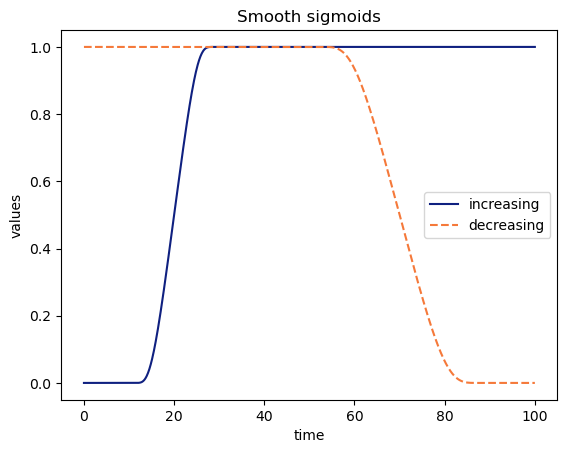

In [8]:
left_taper = taper_function(time, 
            taper_type='left', sigmoid_type='smooth', 
            t0_taper=t0, t1_taper=t1)
right_taper = taper_function(time, 
            taper_type='right', sigmoid_type='smooth', 
            t2_taper=t2, t3_taper=t3)

plt.plot(time, left_taper, label='increasing')
plt.plot(time, right_taper, '--', label='decreasing')
plt.legend()
plt.title('Smooth sigmoids')
plt.xlabel('time')
plt.ylabel('values');

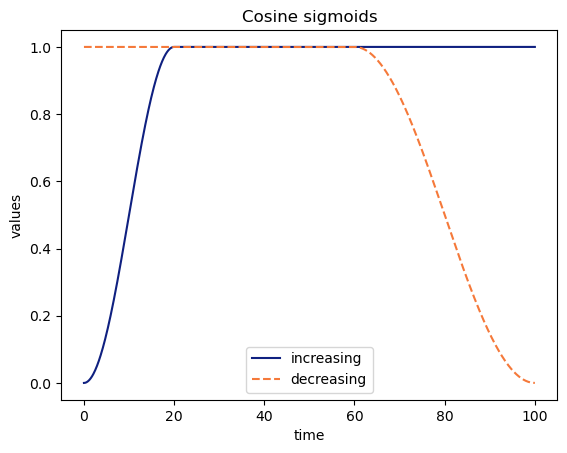

In [9]:
left_taper = taper_function(time, 
            taper_type='left', sigmoid_type='cosine', 
            left_taper_length=20)
right_taper = taper_function(time, 
            taper_type='right', sigmoid_type='cosine', 
            right_taper_length=40)

plt.plot(time, left_taper, label='increasing')
plt.plot(time, right_taper, '--', label='decreasing')
plt.legend()
plt.title('Cosine sigmoids')
plt.xlabel('time')
plt.ylabel('values');

A window function consisting of smooth sigmoids is called a Bump window (and mistakenly a Planck window). A window function consisting of cosine sigmoids is known as a Tukey window.

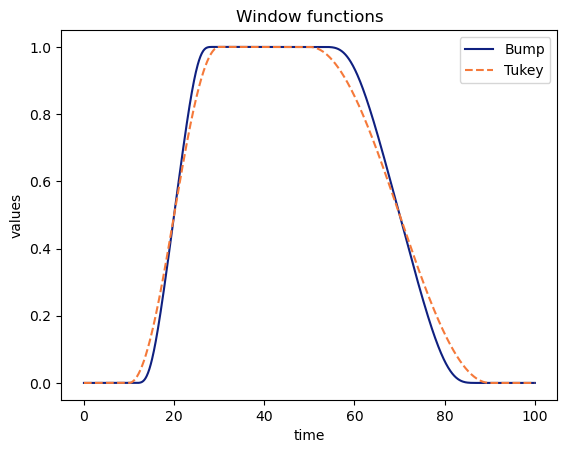

In [10]:
bump_window = taper_function(time, 
            taper_type='both', sigmoid_type='smooth', 
            t0_taper=t0, t1_taper=t1, t2_taper=t2, t3_taper=t3)
tukey_window = taper_function(time, 
            taper_type='both', sigmoid_type='cosine', 
            t0_taper=t0, t1_taper=t1, t2_taper=t2, t3_taper=t3)

plt.plot(time, bump_window, label='Bump')
plt.plot(time, tukey_window, '--', label='Tukey')
plt.legend()
plt.title('Window functions')
plt.xlabel('time')
plt.ylabel('values');

### Tapering the signal

The function `taper` tapers the signal. The argument list is the same as of the `taper_function`.

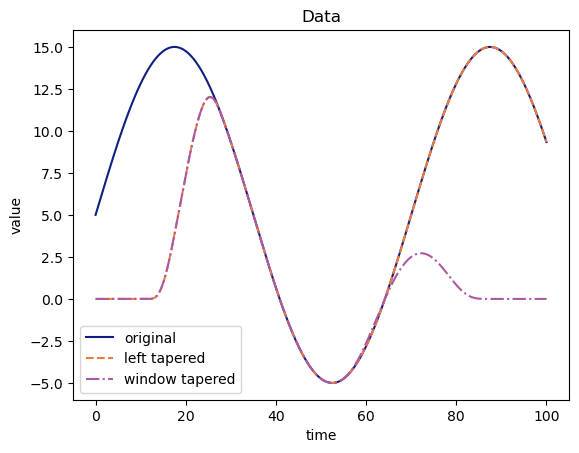

In [11]:
data_tapered_left = taper(time, data, taper_type='left', sigmoid_type='smooth',
                            t0_taper=t0, t1_taper=t1)
data_tapered_window = taper(time, data, taper_type='both', sigmoid_type='smooth',
                            t0_taper=t0, t1_taper=t1, t2_taper=t2, t3_taper=t3)

plt.plot(time, data, label='original')
plt.plot(time, data_tapered_left, '--', label='left tapered')
plt.plot(time, data_tapered_window, '-.', label='window tapered')
plt.legend()
plt.title('Data')
plt.xlabel('time')
plt.ylabel('value');

## Detrending

The function `detrend` removes a straight line from the signal. The input `time` array should be equally spaced. The argument `detrend_type` controls what line to be removed. The option `detrend_type='zero right end'` brings the right end of the signal to zero; the subtraction line connects the points (`time[0]`, 0) and (`time[-1]`+dt, `data[-1]`), where dt is the time spacing (i.e., `time[1]-time[0]`). The option `detrend_type='zero both ends'` brings both ends of the signal to zeros; the subtraction line connects the points (`time[0]`, `data[0]`) and (`time[-1]`+dt, `data[-1]`). 

We use the time stamp `time[-1]`+dt instead of `time[-1]`, because FFT identifies the time stamps `time[0]` and `time[-1]`+dt. We also assume the signal value at `time[-1]`+dt is `data[-1]`; in other words, the signal has settled down to a constant at late times.

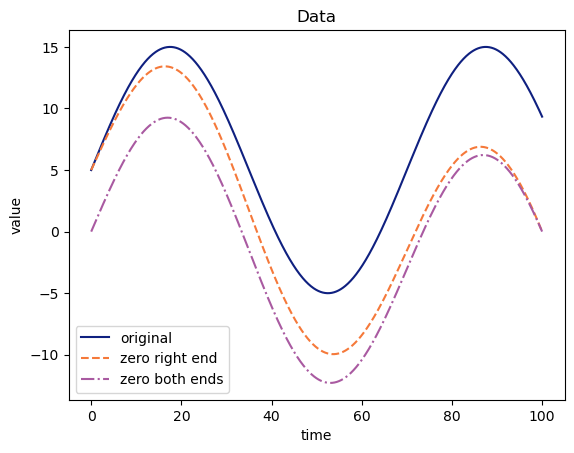

In [12]:
data_detrended_right = detrend(time, data, detrend_type='zero right end')
data_detrended_both = detrend(time, data, detrend_type='zero both ends')

plt.plot(time, data, label='original')
plt.plot(time, data_detrended_right, '--', label='zero right end')
plt.plot(time, data_detrended_both, '-.', label='zero both ends')
plt.legend()
plt.title('Data')
plt.xlabel('time')
plt.ylabel('value');

## General preprocessing function

The function `preprocess_general` combines all four preprocessing steps (tail transitioning, padding, tapering, and detrending). The argument list combines the ones of `transition_tail_to_constant`, `pad`, `taper`, and `detrend`. The input `time` array must be equally spaced. The input `data` array can be 1 or 2 dimensional, and `data.shape[-1]` must match the length of `time`. 

Five quantities are in the output: `data_transitioned`, `time_padded`, `data_padded`, `data_tapered`, and `data_detrended`. The names are self-explanatory. Note that `data_transitioned` has the same shape as `data`; `data_padded.shape[-1]`, `data_tapered.shape[-1]`, and `data_detrended.shape[-1]` match the length of `time_padded`, which is generally different from the length of `time` (except for the no-padding case).

The following graph shows the preprocessed signal in each step. We preprocess the signal in the traditional way: the signal is windowed and no detrending is performed.

In [13]:
t0 = 10
t1 = 30
t2 = 50
t3 = 90

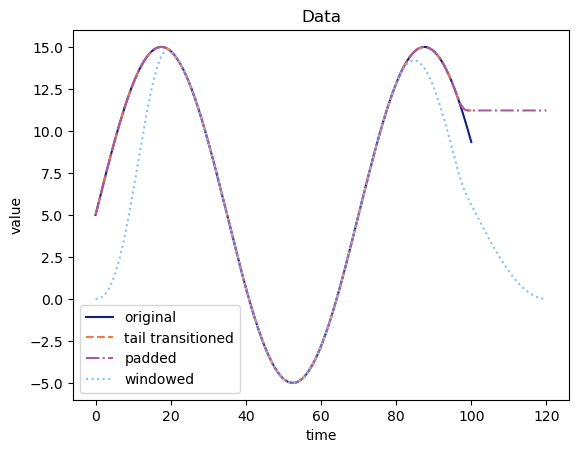

In [14]:
data_transitioned, time_padded, data_padded, data_tapered, data_detrended = \
    preprocess_general(time, data, transition_length=5, pad_type='edge', right_pad_length=20, 
                       taper_type='both', sigmoid_type='cosine', 
                       left_taper_length=20, right_taper_length=40,
                       detrend_type='none')

plt.plot(time, data, label='original')
plt.plot(time, data_transitioned, '--', label='tail transitioned')
plt.plot(time_padded, data_padded, '-.', label='padded')
plt.plot(time_padded, data_tapered, ':', label='windowed')
plt.legend()
plt.title('Data')
plt.xlabel('time')
plt.ylabel('value');

Now, we preprocess the signal in a new way: only the left side of the signal is tapered, and then right end is brought to zero by detrending.

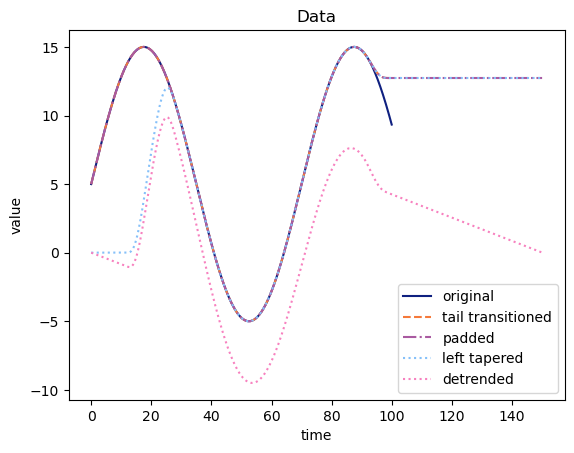

In [15]:
data_transitioned, time_padded, data_padded, data_tapered, data_detrended = \
    preprocess_general(time, data, transition_length=10, pad_type='edge', 
                       left_pad_length=0, right_pad_length=50, 
                       taper_type='left', sigmoid_type='smooth', 
                       t0_taper=t0, t1_taper=t1,
                       detrend_type='zero right end')

plt.plot(time, data, label='original')
plt.plot(time, data_transitioned, '--', label='tail transitioned')
plt.plot(time_padded, data_padded, '-.', label='padded')
plt.plot(time_padded, data_tapered, ':', label='left tapered')
plt.plot(time_padded, data_detrended, ':', label='detrended')
plt.legend()
plt.title('Data')
plt.xlabel('time')
plt.ylabel('value');

## Special preprocessing function

If you only need two default preprocessing schemes, you can use the function `preprocess` instead of `preprocess_general`. The first scheme (`preprocess_type='taper both sides'`) tapers both sides of the signal, followed by no detrending. The second scheme (`preprocess_type='taper left side and detrend'`) tapers only the left side, followed by detrending that brings the right end to zero. You still need to specify the tail-transitioning length, padding lengths, and tapering lengths.

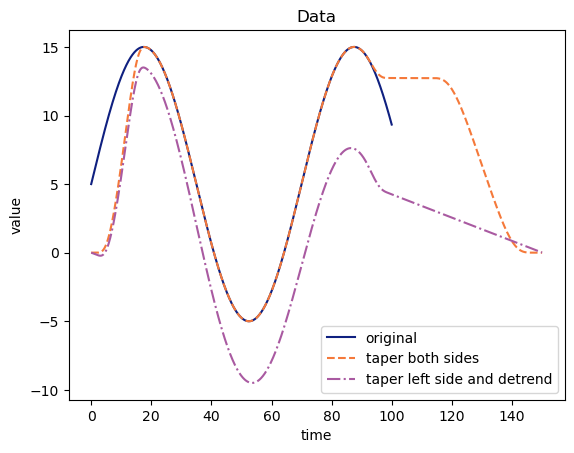

In [16]:
_, time_taper_both, _, _, data_taper_both = \
    preprocess(time, data, preprocess_type='taper both sides',
               transition_length=10, pad_length=50, left_taper_length=20, right_taper_length=40)

_, time_taper_left_detrend, _, _, data_taper_left_detrend = \
    preprocess(time, data, preprocess_type='taper left side and detrend',
               transition_length=10, pad_length=50, left_taper_length=20)

plt.plot(time, data, label='original')
plt.plot(time_taper_both, data_taper_both, '--', label='taper both sides')
plt.plot(time_taper_left_detrend, data_taper_left_detrend, '-.', label='taper left side and detrend')
plt.legend()
plt.title('Data')
plt.xlabel('time')
plt.ylabel('value');

# Actual numerical data: a gravitational waveform

After seeing the effects of preprocessing a simple function, we now move on to preprocess the actual waveform. The following waveform is generated using the SpEC code and then the SpECTRE CCE module. As a CCE waveform, it contains the gravitational memory, especially the displacement memory. For simplicity, the waveform only contains the $\ell=2$ modes, among which the $(\ell=2, m=\pm2)$ modes are the dominant oscillatory modes, and the $(\ell=2, m=0)$ mode is the dominant memory mode. We only need the edge-on view of the system, $(\theta=\pi/2, \phi=0)$, where the memory is maxmized.

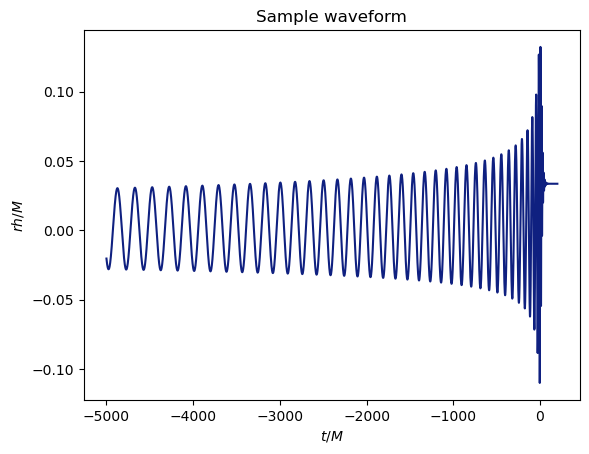

In [17]:
h = sxs.load('sample_CCE.h5')
dt = 0.1
h_interp = h.interpolate(np.arange(h.t[0], h.t[-1], dt))
h_direction = h_interp.evaluate((np.pi/2, 0))

time = h_direction.t
data = h_direction.real.ndarray

plt.plot(time, data)
plt.title('Sample waveform')
plt.xlabel('$t/M$')
plt.ylabel('$rh/M$');

We preprocess the waveform using two different schemes, and the following graph compares the final results of these two schemes.

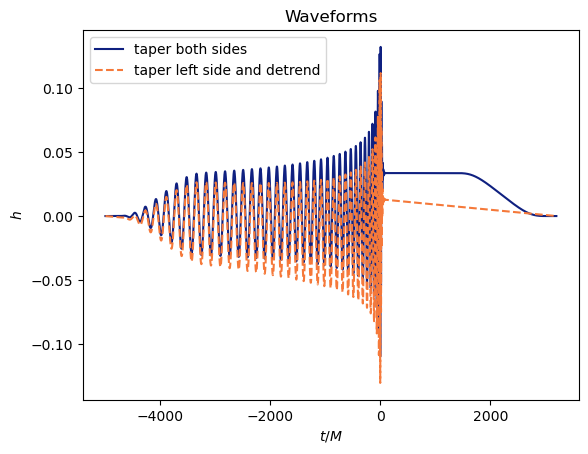

In [18]:
_, time_padded, _, _, data_taper_both = \
    preprocess(time, data, preprocess_type='taper both sides',
               transition_length=20, pad_length=3000, 
               left_taper_length=2000, right_taper_length=2000)

_, _, _, _, data_taper_left_detrend = \
    preprocess(time, data, preprocess_type='taper left side and detrend',
               transition_length=20, pad_length=3000, 
               left_taper_length=2000)

plt.plot(time_padded, data_taper_both, label='taper both sides')
plt.plot(time_padded, data_taper_left_detrend, '--', label='taper left side and detrend')
plt.legend()
plt.title('Waveforms')
plt.xlabel('$t/M$')
plt.ylabel('$h$');

Different preprocessing schemes do affect the frequency spectra of the waveform. The next graph shows the spectra of the preprocessed waveforms in the previous graph. Note that the `'taper left side and detrend'` scheme has a straighter low spectrum, while the `label='taper both sides'` contains zigzags in the low frequency range.

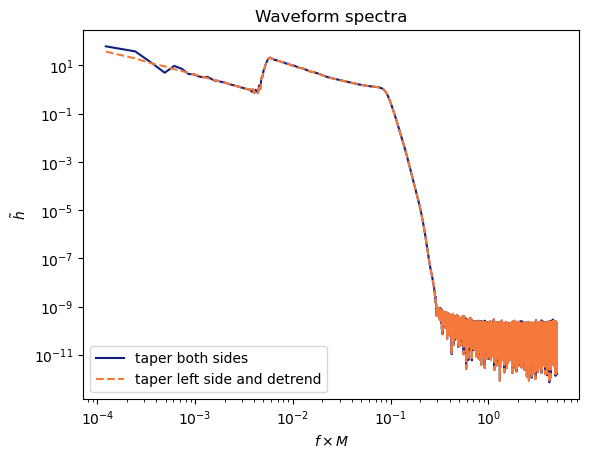

In [19]:
freq = np.fft.rfftfreq(len(time_padded), dt)
data_taper_both_fft = np.fft.rfft(data_taper_both, axis = -1)*dt
data_taper_left_detrend_fft = np.fft.rfft(data_taper_left_detrend, axis = -1)*dt

plt.loglog(freq[freq>0], abs(data_taper_both_fft)[freq>0], label='taper both sides')
plt.loglog(freq[freq>0], abs(data_taper_left_detrend_fft)[freq>0], '--', label='taper left side and detrend')
plt.legend()
plt.title('Waveform spectra')
plt.xlabel(r'$f\times M$')
plt.ylabel(r'$\tilde{h}$');

For a binary-black-hole system of $65M_\odot$ and 410 Mpc away, the time- and frequency-domain waveforms (after being preprocessed) are shown in the following graphs, in SI units.

In [20]:
mass_in_Msun = 65
distance_in_Mpc = 410
solarmass_to_Mpc = sxs.m_sun_in_meters/sxs.parsec_in_meters/1e6

time_si = time_padded*sxs.m_sun_in_seconds*mass_in_Msun
data_taper_both_si = data_taper_both*solarmass_to_Mpc*mass_in_Msun/distance_in_Mpc
data_taper_left_detrend_si = data_taper_left_detrend*solarmass_to_Mpc*mass_in_Msun/distance_in_Mpc

freq_si = freq/sxs.m_sun_in_seconds/mass_in_Msun
data_taper_both_fft_si = data_taper_both_fft*solarmass_to_Mpc*sxs.m_sun_in_seconds/distance_in_Mpc*mass_in_Msun**2
data_taper_left_detrend_fft_si = data_taper_left_detrend_fft*solarmass_to_Mpc*sxs.m_sun_in_seconds/distance_in_Mpc*mass_in_Msun**2

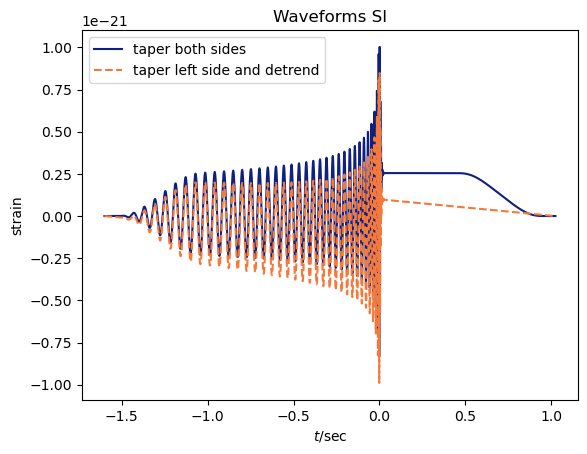

In [21]:
plt.plot(time_si, data_taper_both_si, label='taper both sides')
plt.plot(time_si, data_taper_left_detrend_si, '--', label='taper left side and detrend')
plt.legend()
plt.title('Waveforms SI')
plt.xlabel('$t/$sec')
plt.ylabel('strain');

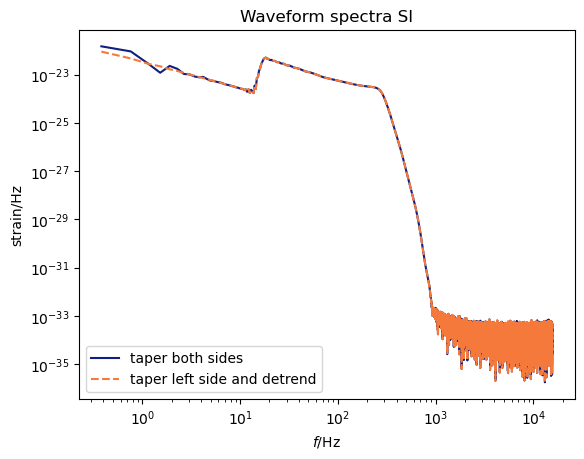

In [22]:
plt.loglog(freq_si[freq_si>0], abs(data_taper_both_fft_si)[freq_si>0], label='taper both sides')
plt.loglog(freq_si[freq_si>0], abs(data_taper_left_detrend_fft_si)[freq_si>0], '--', label='taper left side and detrend')
plt.legend()
plt.title('Waveform spectra SI')
plt.xlabel('$f/$Hz')
plt.ylabel('strain/Hz');